In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
PATH_BASE="/content/drive/MyDrive/Project III/als-recommender-pyspark"
PATH_MOVIES=f"{PATH_BASE}/movies.csv"
PATH_RATINGS=f"{PATH_BASE}/ratings.csv"

PATH_SMALL_DATA=f"{PATH_BASE}/small data"
PATH_SMALL_DATA_001=f"{PATH_SMALL_DATA}/data001.csv"
PATH_SMALL_DATA_ALL=f"{PATH_SMALL_DATA}/data*.csv"

PATH_SMALL_DATA_SALES=f"{PATH_SMALL_DATA}/supermarket_sales.csv"

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 52.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=f523d4f1b9470c5d7db904e1e161ea370d2cf36e2aaeef75bdadc5c96ba88c8a
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


# ETL: 
- Compare traditional and Spark.

### Import libraries

In [ ]:
#https://grouplens.org/datasets/movielens/

In [31]:
import pandas as pd
import time
import numpy as np

from pyspark.sql.functions import col, explode
from pyspark import SparkContext

### Initiate spark session

In [11]:
from pyspark.sql import SparkSession
ss= SparkSession.builder.appName('Recommendations').getOrCreate()

In [20]:
data=ss.read.csv(PATH_SMALL_DATA_ALL,header=True)

In [21]:
print(f"num records: {data.count()}")
data.toPandas()

num records: 8


,name,age,country
0,noreen,23,England
1,Aamir,9,Pakistan
2,Noman,4,Pakistan
3,Rasheed,12,Pakistan
4,adnan,40,Pakistan
5,maaz,9,Pakistan
6,musab,4,Pakistan
7,ayesha,32,Pakistan


# Storage level: 
- docs: https://spark.apache.org/docs/3.2.0/rdd-programming-guide.html#rdd-persistence
- TODO: Compare read in 2 modes MEMORY_AND_DISK and MEMORY_ONLY in "reading" and "group".

In [39]:
times=[]
for i in range(10):
  start=time.time()
  data=ss.read.csv(PATH_SMALL_DATA_SALES,header=True).cache()
  times.append(time.time()-start)
np.array(times).mean()

0.32845268249511717

In [47]:
data=ss.read.csv(PATH_SMALL_DATA_SALES,header=True).cache()
data.toPandas()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761904762,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.82,80.22,3/8/2019,10:29,Cash,76.4,4.761904762,3.82,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761904762,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.288,489.048,1/27/2019,20:33,Ewallet,465.76,4.761904762,23.288,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761904762,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761904762,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.69,1022.49,3/2/2019,17:16,Ewallet,973.8,4.761904762,48.69,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.592,33.432,2/9/2019,13:22,Cash,31.84,4.761904762,1.592,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.291,69.111,2/22/2019,15:33,Cash,65.82,4.761904762,3.291,4.1


In [48]:
start=time.time()
gender = data.groupBy('Gender').count()
print(time.time()-start)
gender.toPandas()

0.013992071151733398


,Gender,count
0,Female,501
1,Male,499


In [51]:
data.createOrReplaceTempView ("sales")
output =  ss.sql('SELECT * from sales')
output.toPandas()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761904762,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.82,80.22,3/8/2019,10:29,Cash,76.4,4.761904762,3.82,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761904762,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.288,489.048,1/27/2019,20:33,Ewallet,465.76,4.761904762,23.288,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761904762,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761904762,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.69,1022.49,3/2/2019,17:16,Ewallet,973.8,4.761904762,48.69,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.592,33.432,2/9/2019,13:22,Cash,31.84,4.761904762,1.592,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.291,69.111,2/22/2019,15:33,Cash,65.82,4.761904762,3.291,4.1


In [58]:
output = ss.sql('SELECT * from sales WHERE `Unit Price` < 15 AND Quantity < 10')
output.toPandas()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,351-62-0822,B,Mandalay,Member,Female,Fashion accessories,14.48,4,2.896,60.816,2/6/2019,18:07,Ewallet,57.92,4.761904762,2.896,4.5
1,871-39-9221,C,Naypyitaw,Normal,Female,Electronic accessories,12.45,6,3.735,78.435,2/9/2019,13:11,Cash,74.7,4.761904762,3.735,4.1
2,586-25-0848,A,Yangon,Normal,Female,Sports and travel,12.34,7,4.319,90.699,3/4/2019,11:19,Credit card,86.38,4.761904762,4.319,6.7
3,389-25-3394,C,Naypyitaw,Normal,Male,Electronic accessories,11.81,5,2.9525,62.0025,2/17/2019,18:06,Cash,59.05,4.761904762,2.9525,9.4
4,279-62-1445,C,Naypyitaw,Member,Female,Fashion accessories,12.54,1,0.627,13.167,2/21/2019,12:38,Cash,12.54,4.761904762,0.627,8.2
5,545-46-3100,B,Mandalay,Member,Female,Electronic accessories,10.59,3,1.5885,33.3585,3/12/2019,13:52,Credit card,31.77,4.761904762,1.5885,8.7
6,346-84-3103,B,Mandalay,Member,Female,Electronic accessories,13.22,5,3.305,69.405,3/2/2019,19:26,Cash,66.1,4.761904762,3.305,4.3
7,883-17-4236,C,Naypyitaw,Normal,Female,Sports and travel,14.39,2,1.439,30.219,3/2/2019,19:44,Credit card,28.78,4.761904762,1.439,7.2
8,633-91-1052,A,Yangon,Normal,Female,Home and lifestyle,12.03,2,1.203,25.263,1/27/2019,15:51,Cash,24.06,4.761904762,1.203,5.1
9,396-90-2219,B,Mandalay,Normal,Female,Electronic accessories,14.96,8,5.984,125.664,2/23/2019,12:29,Cash,119.68,4.761904762,5.984,8.6


In [53]:
# output = ss.sql('SELECT COUNT(*) as total, City from sales GROUP BY City')
# output.toPandas()

,total,City
0,328,Naypyitaw
1,332,Mandalay
2,340,Yangon


In [61]:
output.write.format('json').save('filtered001.json')

In [62]:
preprocessed_data=ss.read.json("filtered001.json").cache()
preprocessed_data.toPandas()

,Branch,City,Customer type,Date,Gender,Invoice ID,Payment,Product line,Quantity,Rating,Tax 5%,Time,Total,Unit price,cogs,gross income,gross margin percentage
0,B,Mandalay,Member,2/6/2019,Female,351-62-0822,Ewallet,Fashion accessories,4,4.5,2.896,18:07,60.816,14.48,57.92,2.896,4.761904762
1,C,Naypyitaw,Normal,2/9/2019,Female,871-39-9221,Cash,Electronic accessories,6,4.1,3.735,13:11,78.435,12.45,74.7,3.735,4.761904762
2,A,Yangon,Normal,3/4/2019,Female,586-25-0848,Credit card,Sports and travel,7,6.7,4.319,11:19,90.699,12.34,86.38,4.319,4.761904762
3,C,Naypyitaw,Normal,2/17/2019,Male,389-25-3394,Cash,Electronic accessories,5,9.4,2.9525,18:06,62.0025,11.81,59.05,2.9525,4.761904762
4,C,Naypyitaw,Member,2/21/2019,Female,279-62-1445,Cash,Fashion accessories,1,8.2,0.627,12:38,13.167,12.54,12.54,0.627,4.761904762
5,B,Mandalay,Member,3/12/2019,Female,545-46-3100,Credit card,Electronic accessories,3,8.7,1.5885,13:52,33.3585,10.59,31.77,1.5885,4.761904762
6,B,Mandalay,Member,3/2/2019,Female,346-84-3103,Cash,Electronic accessories,5,4.3,3.305,19:26,69.405,13.22,66.1,3.305,4.761904762
7,C,Naypyitaw,Normal,3/2/2019,Female,883-17-4236,Credit card,Sports and travel,2,7.2,1.439,19:44,30.219,14.39,28.78,1.439,4.761904762
8,A,Yangon,Normal,1/27/2019,Female,633-91-1052,Cash,Home and lifestyle,2,5.1,1.203,15:51,25.263,12.03,24.06,1.203,4.761904762
9,B,Mandalay,Normal,2/23/2019,Female,396-90-2219,Cash,Electronic accessories,8,8.6,5.984,12:29,125.664,14.96,119.68,5.984,4.761904762


# 1. Load data

In [ ]:
movies = spark.read.csv(PATH_MOVIES,header=True)
ratings = spark.read.csv(PATH_RATINGS,header=True)

In [ ]:
print(f"movies num: {movies.count()}")
print(f"ratings num: {ratings.count()}")

movies num: 9742
ratings num: 100836


In [ ]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
ratings = ratings.\
    withColumn('userId', col('userId').cast('integer')).\
    withColumn('movieId', col('movieId').cast('integer')).\
    withColumn('rating', col('rating').cast('float')).\
    drop('timestamp').\
ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [ ]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
movies_preprocessed= movies.\
    withColumn('movieId', col('movieId')).\
    drop('genres','title')


ratings_preprocessed= ratings.\
    withColumn('movieId', col('movieId')).\
    drop('genres','title')
  
movies_preprocessed.toPandas()

,movieId
0,1
1,2
2,3
3,4
4,5
...,...
9737,193581
9738,193583
9739,193585
9740,193587


In [ ]:
ratings.count()

100836

In [ ]:
ratings_pivot=ratings.groupBy("movieId").pivot("userId").sum("rating")
ratings_pivot

DataFrame[movieId: int, 1: double, 2: double, 3: double, 4: double, 5: double, 6: double, 7: double, 8: double, 9: double, 10: double, 11: double, 12: double, 13: double, 14: double, 15: double, 16: double, 17: double, 18: double, 19: double, 20: double, 21: double, 22: double, 23: double, 24: double, 25: double, 26: double, 27: double, 28: double, 29: double, 30: double, 31: double, 32: double, 33: double, 34: double, 35: double, 36: double, 37: double, 38: double, 39: double, 40: double, 41: double, 42: double, 43: double, 44: double, 45: double, 46: double, 47: double, 48: double, 49: double, 50: double, 51: double, 52: double, 53: double, 54: double, 55: double, 56: double, 57: double, 58: double, 59: double, 60: double, 61: double, 62: double, 63: double, 64: double, 65: double, 66: double, 67: double, 68: double, 69: double, 70: double, 71: double, 72: double, 73: double, 74: double, 75: double, 76: double, 77: double, 78: double, 79: double, 80: double, 81: double, 82: double, 8

In [ ]:
'''
- Calculate NaN:
'''

from pyspark.sql.functions import isnan, when, count, col


stats=ratings_pivot.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ratings_pivot.columns])

In [ ]:
'''
TODO: - https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/best_practices/prefer_reducebykey_over_groupbykey.html
'''

'\nTODO: - https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/best_practices/prefer_reducebykey_over_groupbykey.html\n'

In [ ]:
ratings_pivot.toPandas()

,movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
0,1580,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,2.0,NaN,4.5,NaN,NaN,4.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,3.0,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,3.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,3.5,NaN,NaN,1.5,4.5,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,2.5,3.0,3.5,NaN,NaN
1,3175,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.0,4.0,NaN,NaN
2,1645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.5,NaN,4.5,NaN,NaN
3,6466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.5,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,1.5,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,44657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9720,146688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9721,44613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN
9722,73501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
'''
- Calculate sparsity:
'''
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()
num_ratings= ratings.select("rating").count()
sparsity=(1-(num_ratings)/(num_users*num_movies))
print(f"sparsity: {round(sparsity*100,2)}%")

sparsity: 98.3%


## Interpret ratings

In [ ]:
# Group data by userId, count ratings
userId_ratings = ratings.groupBy("userId").count().orderBy('count', ascending=False)
userId_ratings.show()

+------+-----+
|userId|count|
+------+-----+
|   414| 2698|
|   599| 2478|
|   474| 2108|
|   448| 1864|
|   274| 1346|
|   610| 1302|
|    68| 1260|
|   380| 1218|
|   606| 1115|
|   288| 1055|
|   249| 1046|
|   387| 1027|
|   182|  977|
|   307|  975|
|   603|  943|
|   298|  939|
|   177|  904|
|   318|  879|
|   232|  862|
|   480|  836|
+------+-----+
only showing top 20 rows



In [ ]:
# Group data by userId, count ratings
movieId_ratings = ratings.groupBy("movieId").count().orderBy('count', ascending=False)
movieId_ratings.show()

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
|    260|  251|
|    480|  238|
|    110|  237|
|    589|  224|
|    527|  220|
|   2959|  218|
|      1|  215|
|   1196|  211|
|   2858|  204|
|     50|  204|
|     47|  203|
|    780|  202|
|    150|  201|
|   1198|  200|
|   4993|  198|
+-------+-----+
only showing top 20 rows



## Build Out An ALS Model

In [ ]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
'''
[NOTE]: 
- ref: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html
- rank: https://stackoverflow.com/questions/30729656/what-is-rank-in-als-machine-learning-algorithm-in-apache-spark-mllib
'''

# Create test and train set
(training, testing)= ratings.randomSplit([0.8, 0.2])

# # Create ALS model
# als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

# # Confirm that a model called "als" was created
# type(als)

# Build the recommendation model using ALS on the training data
# # Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
# model=als.fit(training)


In [ ]:
import time

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

iters=range(1,22)
rmses=[]

for i in iters:
  start=time.time()

  als = ALS(rank=9,regParam=0.15,maxIter=i,userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
  model = als.fit(training)
  predictions = model.transform(testing)
  rmse = evaluator.evaluate(predictions)
  rmses.append(rmse)

  print(time.time()-start)

4.417845010757446
5.771747589111328
6.3027589321136475
6.662517070770264
7.531983852386475
6.863328218460083
7.728853464126587
7.967968463897705
7.2850446701049805
9.660295248031616
9.440160751342773
9.82610559463501
11.640825271606445
11.524996757507324
11.801315307617188
11.283601760864258
13.831786632537842
13.48540210723877
14.10528039932251
15.57010006904602
15.009952783584595


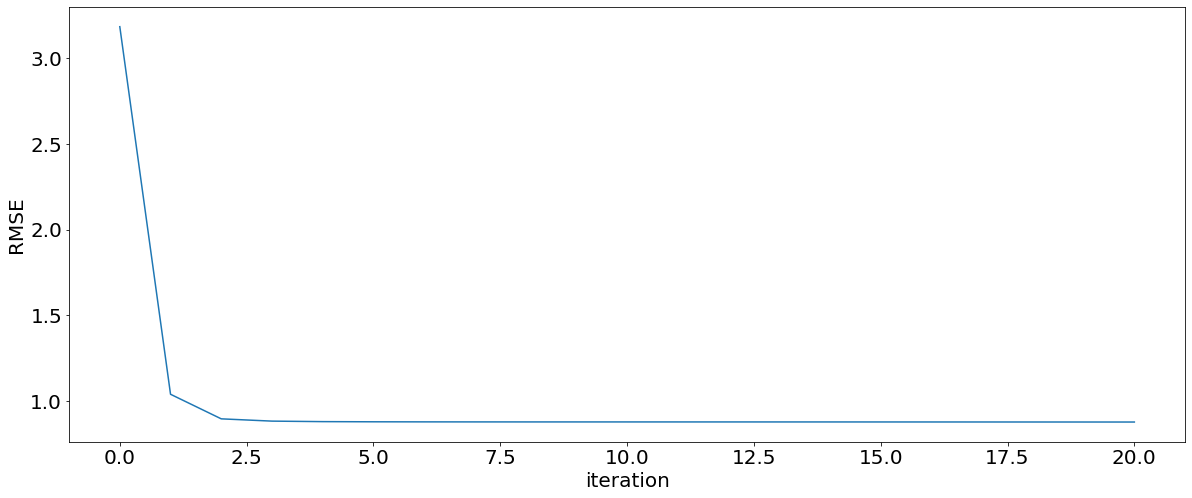

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [20.00, 8.0]
font = {'size'   : 20}

plt.rc('font', **font)
plt.plot(rmses)
plt.ylabel('RMSE')
plt.xlabel('iteration')
# plt.xticks(range(len(regParams)), regParams)
plt.show()

In [ ]:
als = ALS(rank=9,regParam=0.15,maxIter=3,userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

In [ ]:
als = ALS(rank=9,regParam=0.15,maxIter=3,userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

predictions = model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

RMSE: 0.895895873320047


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
user_recommendation = model.recommendForAllUsers(2)
user_recommendation.toPandas()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,userId,recommendations
0,1,"[(5915, 6.04165506362915), (89759, 6.038002014..."
1,2,"[(8477, 5.38855504989624), (27156, 5.246457576..."
2,3,"[(70946, 5.3346171379089355), (5746, 4.8906946..."
3,4,"[(6611, 5.006802082061768), (160644, 5.0068020..."
4,5,"[(1046, 5.284482002258301), (4495, 5.139161586..."
...,...,...
605,606,"[(1046, 5.053971767425537), (7121, 5.035173416..."
606,607,"[(1046, 5.380115032196045), (112804, 5.1709065..."
607,608,"[(5915, 4.647209167480469), (30745, 4.59754371..."
608,609,"[(1046, 4.702937602996826), (112804, 4.6135153..."


In [ ]:
import pyspark.sql.functions as sf
user_recs= movies_preprocessed.select("movieId").withColumn("userId", sf.lit(500))
user_recs.toPandas()

,movieId,userId
0,1,500
1,2,500
2,3,500
3,4,500
4,5,500
...,...,...
9737,193581,500
9738,193583,500
9739,193585,500
9740,193587,500


In [ ]:
user_recs= model.transform(user_recs)
user_recs=user_recs.orderBy('prediction', ascending=False).select("movieId", "prediction")
user_recs.toPandas()

,movieId,prediction
0,4794,5.005937
1,5490,4.854012
2,132333,4.854012
3,5915,4.820347
4,89904,4.682043
...,...,...
8995,5764,-0.355037
8996,7899,-0.355037
8997,5746,-0.394486
8998,6835,-0.394486


In [ ]:
user_recs.join(movies,user_recs.movieId==movies.movieId).select("title").toPandas()

,title
0,Toy Story (1995)
1,Jumanji (1995)
2,Grumpier Old Men (1995)
3,Waiting to Exhale (1995)
4,Father of the Bride Part II (1995)
...,...
8995,Jon Stewart Has Left the Building (2015)
8996,Black Butler: Book of the Atlantic (2017)
8997,Flint (2017)
8998,Bungo Stray Dogs: Dead Apple (2018)
